# WIP: A Quick PyTorch 2.0 Tutorial

In short:

If you have a new GPU (NVIDIA 40XX or A100, A10G etc), you can "compile" your models and often see speed ups.

**Before PyTorch 2.0:**

```python
import torch

model = create_model()

### Train model ###

### Test model ###
```

**After PyTorch 2.0:**

```python
import torch

model = create_model()
compiled_model = torch.compile(model) # <- new!

### Train model ### <- faster!

### Test model ### <- faster!
```

Things to note:
* TK - add where it doesn't work

## TK - Resources to learn more
* PyTorch 2.0 launch blog post - https://pytorch.org/get-started/pytorch-2.0/ 
* PyTorch 2.0 release notes - https://pytorch.org/blog/pytorch-2.0-release/ 
    * GitHub release notes - https://github.com/pytorch/pytorch/releases/tag/v2.0.0 (lots of info here!)
* PyTorch default device context manager - https://github.com/pytorch/tutorials/pull/2220/files 

In [70]:
# See here: https://github.com/pytorch/tutorials/pull/2220/files 
import torch
with torch.device('cuda'):
    mod = torch.nn.Linear(20, 30)
    print(mod.weight.device)
    print(mod(torch.randn(128, 20)).device)

cuda:0
cuda:0


In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.backends.cudnn.version())

11.8
True
8700


In [2]:
# Install PyTorch 2.0 (currently from nightlies)
import torch

# Check PyTorch version
pt_version = torch.__version__
print(f"PyTorch version: {pt_version} (should be 2.x+)")

# Install PyTorch 2.0 (currently from nightlies)
if pt_version.split(".")[0] == "1": # Check if PyTorch version begins with 1 
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    print("[INFO] PyTorch 2.x installed, if you're on Google Colab, you may need to restart your runtime.")
else:
    print("[INFO] PyTorch 2.x installed, you'll be able to use the new features.")

PyTorch version: 2.1.0.dev20230313 (should be 2.x+)
[INFO] PyTorch 2.0 installed, you'll be able to use the new features.


TODO: 
* add in info about PyTorch 2.0
* a quick upgrade for speed ups
* a quick note on which GPU will be needed (works best on NVIDIA GPUs, not macOS)

## TK - Check GPU

* Best speedups are on newer NVIDIA GPUs (this is because PyTorch 2.0 leverages new NVIDIA hardware)

In [3]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(f"GPU information:\n{gpu_info}")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  print(f'GPU name: {gpu_name}')

  # Get GPU capability score
  gpu_score = torch.cuda.get_device_capability()
  print(f"GPU capability score: {gpu_score}")

GPU information:
Thu Mar 16 06:37:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8    11W / 320W |    101MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                       

* TK - add a table for NVIDIA GPUs and architectures etc and which lead to speedups

## TK - Simple training example 

* CIFAR10
* ResNet50

In [4]:
import torch
print(f"PyTorch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.1.0.dev20230313
Using device: cuda


In [5]:
import torchvision

print(f"TorchVision version: {torchvision.__version__}")

TorchVision version: 0.15.0.dev20230313


### Create model and transforms

In [6]:
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
transforms = model_weights.transforms()
model = torchvision.models.resnet50(weights=model_weights)

total_params = sum(
	param.numel() for param in model.parameters()
)

print(total_params)

25557032


In [7]:
print(transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [8]:
transforms.crop_size = 32
transforms.resize_size = 32 # Resize to 32x32, CIFAR10 is 32x32

In [9]:
transforms

ImageClassification(
    crop_size=32
    resize_size=32
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### Make datasets

In [10]:
train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transforms)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

Files already downloaded and verified
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


### Create DataLoaders

* Generally GPUs aren't the bottleneck of ML code
* Data loading is the main bottleneck
    * E.g. you want to get your data to the GPU as fast as possible = more workers (though in my experience this generally caps at about ~4 workers per GPU, though don't trust me, better to do your own experiments)
* You want your GPUs to go brrrrr - https://horace.io/brrr_intro.html 
    * More here on crazy matmul improvements - https://twitter.com/cHHillee/status/1630274804795445248?s=20 

In [11]:
from torch.utils.data import DataLoader

# Create DataLoaders
import os
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

# Print details
print(f"Train dataloader length: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {BATCH_SIZE}")
print(f"Using number of workers: {NUM_WORKERS} (generally more workers means faster dataloading from CPU to GPU)")

Train dataloader length: 391 batches of size 128
Test dataloader length: 79 batches of size 128
Using number of workers: 16 (generally more workers means faster dataloading from CPU to GPU)


In [28]:
# Create filename to save the results
dataset_name = "CIFAR10"
model_name = "ResNet50"

### Create training loops

In [12]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader), 
        desc=f"Training Epoch {epoch}", 
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader), 
      desc=f"Testing Epoch {epoch}", 
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch, 
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time
      
      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

In [13]:
import torch 
import torchvision

def create_model():
  model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)
  # TK - adjust the output layer shape for CIFAR10
  model.fc = torch.nn.Linear(2048, 10)
  return model, transforms

model, transforms = create_model()

In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
NUM_EPOCHS = 2

In [16]:
model, transforms = create_model()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr=0.003)

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=NUM_EPOCHS,
                device=device)

  0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1024 | train_acc: 0.6368 | test_loss: 1.7512 | test_acc: 0.4925 | train_epoch_time: 10.5276 | test_epoch_time: 1.3578


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.0224 | train_acc: 0.6616 | test_loss: 0.9931 | test_acc: 0.6658 | train_epoch_time: 8.3536 | test_epoch_time: 1.2717


In [17]:
model, transforms = create_model()
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr=0.003)

compile_start_time = time.time()
### New in PyTorch 2.x ###
compiled_model = torch.compile(model)
##########################
compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")

compile_results = train(model=compiled_model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

Time to compile: 0.11189961433410645 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

/home/daniel/code/pytorch/env-nightly/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:93: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1955 | train_acc: 0.6053 | test_loss: 0.9915 | test_acc: 0.6735 | train_epoch_time: 34.9682 | test_epoch_time: 10.3872


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.8678 | train_acc: 0.7083 | test_loss: 1.2752 | test_acc: 0.5839 | train_epoch_time: 9.2625 | test_epoch_time: 1.2016


In [18]:
# Create the graphs of results and compiled_results
import pandas as pd
results_df = pd.DataFrame(results)
compile_results_df = pd.DataFrame(compile_results)

In [19]:
results_df.head()

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.102421,0.636765,1.751239,0.492484,10.527614,1.357769
1,1.022397,0.661617,0.993084,0.665843,8.353620,1.271722


### TK - Make this more obvious that it's for a single run

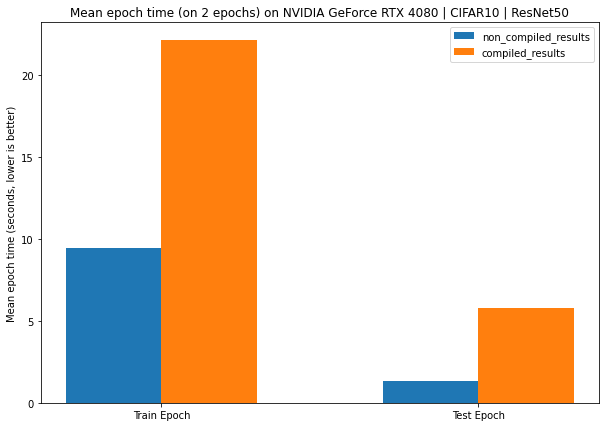

In [29]:
mean_train_epoch_time = results_df.train_epoch_time.mean()
mean_test_epoch_time = results_df.test_epoch_time.mean()
mean_results = [mean_train_epoch_time, mean_test_epoch_time]

mean_compile_train_epoch_time = compile_results_df.train_epoch_time.mean()
mean_compile_test_epoch_time = compile_results_df.test_epoch_time.mean()
mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

# Create a bar plot of the mean train and test epoch time for both results and compiled_results
# Make both bars appear on the same plot
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))
width = 0.3
x_indicies = np.arange(len(mean_results))

plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
plt.ylabel("Mean epoch time (seconds, lower is better)")
# TK - make this title include dataset/model information for a better idea of what's happening
plt.title(f"Mean epoch time (on {NUM_EPOCHS} epochs) on {gpu_name} | {dataset_name} | {model_name}")
plt.legend();

# mean_train_epoch_time, mean_compile_train_epoch_time

In [24]:
mean_test_epoch_time, mean_compile_test_epoch_time

(1.3147454261779785, 5.7943936586380005)

## TK - Save results to file with GPU details

TODO:
* Save the results to file with GPU name and other details (run on multiple machines)
* Run for multiple passes (e.g. 5x runs to average the time over each run)

In [25]:
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{dataset_name}_{model_name}_{gpu_name.replace(' ', '_')}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{dataset_name}_{model_name}_{gpu_name.replace(' ', '_')}.csv"
save_name_for_non_compiled_results, save_name_for_compiled_results

('single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_4080.csv',
 'single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_4080.csv')

In [26]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Save the results
results_df.to_csv(f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}")
compile_results_df.to_csv(f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}")


## TK - Try for multiple runs

In [34]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=False):
    model, transforms = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.003)

    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)
    return results

# TK - change this to only compile a model once and then run the training loop multiple times
# TK - the first time you compile a model, the first few epochs will be slower than subsequent runs
# TK - consider the first few epochs of training to be a "warmup" period
# def create_and_train_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=False):
#     model, transforms = create_model()
#     model.to(device)
#     loss_fn = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(),
#                                  lr=0.003)
    
#     compile_start_time = time.time()
#     ### New in PyTorch 2.x ###
#     compiled_model = torch.compile(model)
#     ##########################
#     compile_end_time = time.time()
#     compile_time = compile_end_time - compile_start_time
#     print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")

#     compile_results = train(model=compiled_model,
#                             train_dataloader=train_dataloader,
#                             test_dataloader=test_dataloader,
#                             loss_fn=loss_fn,
#                             optimizer=optimizer,
#                             epochs=NUM_EPOCHS,
#                             device=device,
#                             disable_progress_bar=disable_progress_bar)
    
#     return compile_results

def create_compiled_model():
    model, _ = create_model()
    model.to(device)
    
    compile_start_time = time.time()
    ### New in PyTorch 2.x ###
    compiled_model = torch.compile(model)
    ##########################
    compile_end_time = time.time()
    compile_time = compile_end_time - compile_start_time
    print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")
    return compiled_model

def train_compiled_model(model=compiled_model, epochs=NUM_EPOCHS, disable_progress_bar=False):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(compiled_model.parameters(),
                                 lr=0.003)
    
    compile_results = train(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=epochs,
                            device=device,
                            disable_progress_bar=disable_progress_bar)
    
    return compile_results

In [59]:
# Run non-compiled model for multiple runs
NUM_RUNS = 5
NUM_EPOCHS = 5

non_compile_results_multiple_runs = []
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
    results = create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=True)
    non_compile_results_multiple_runs.append(results)

  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Run 1 of 5 for non-compiled model
Epoch: 1 | train_loss: 1.0233 | train_acc: 0.6613 | test_loss: 0.9620 | test_acc: 0.6944 | train_epoch_time: 8.3822 | test_epoch_time: 1.3666
Epoch: 2 | train_loss: 0.6470 | train_acc: 0.7874 | test_loss: 0.6907 | test_acc: 0.7712 | train_epoch_time: 8.4705 | test_epoch_time: 1.4128
Epoch: 3 | train_loss: 0.5098 | train_acc: 0.8303 | test_loss: 0.6589 | test_acc: 0.7859 | train_epoch_time: 8.5455 | test_epoch_time: 1.3712
Epoch: 4 | train_loss: 0.4998 | train_acc: 0.8339 | test_loss: 0.6213 | test_acc: 0.7997 | train_epoch_time: 8.3854 | test_epoch_time: 1.3645
Epoch: 5 | train_loss: 0.3691 | train_acc: 0.8776 | test_loss: 0.6080 | test_acc: 0.8015 | train_epoch_time: 8.3813 | test_epoch_time: 1.4081
[INFO] Run 2 of 5 for non-compiled model
Epoch: 1 | train_loss: 1.1189 | train_acc: 0.6290 | test_loss: 7.4376 | test_acc: 0.5281 | train_epoch_time: 8.3968 | test_epoch_time: 1.3925
Epoch: 2 | train_loss: 1.0737 | train_acc: 0.6471 | test_loss: 1.1

In [60]:
# Go through non_compile_results_multiple_runs and create a dataframe for each run then concatenate them together
non_compile_results_dfs = []
for result in non_compile_results_multiple_runs:
    result_df = pd.DataFrame(result)
    non_compile_results_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_results_dfs)

# Get the averages across the multiple runs
non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()
non_compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.091867,0.639470,2.832797,0.596737,8.472784,1.394672
1,0.857212,0.719047,1.644164,0.594086,8.470718,1.385634
2,0.887548,0.705594,0.862998,0.720372,8.398150,1.392065
3,0.640245,0.785117,0.797481,0.742583,8.448480,1.386481
4,0.546334,0.816775,0.670329,0.777888,8.431838,1.392111


In [61]:
# TK - change this to only compile a model once and then run the training loop multiple times
# Create compiled model
compiled_model = create_compiled_model()

compiled_results_multiple_runs = []
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
    results = train_compiled_model(model=compiled_model, epochs=NUM_EPOCHS, disable_progress_bar=True)
    compiled_results_multiple_runs.append(results)

Time to compile: 0.0013861656188964844 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Run 1 of 5 for compiled model
Epoch: 1 | train_loss: 1.1913 | train_acc: 0.6179 | test_loss: 2.8806 | test_acc: 0.3488 | train_epoch_time: 32.6434 | test_epoch_time: 10.1572
Epoch: 2 | train_loss: 1.0352 | train_acc: 0.6587 | test_loss: 0.8406 | test_acc: 0.7210 | train_epoch_time: 9.0170 | test_epoch_time: 1.3055
Epoch: 3 | train_loss: 0.6275 | train_acc: 0.7891 | test_loss: 0.7265 | test_acc: 0.7495 | train_epoch_time: 8.9066 | test_epoch_time: 1.2959
Epoch: 4 | train_loss: 0.5166 | train_acc: 0.8256 | test_loss: 0.6559 | test_acc: 0.7826 | train_epoch_time: 8.8731 | test_epoch_time: 1.2713
Epoch: 5 | train_loss: 1.3533 | train_acc: 0.5850 | test_loss: 1.5189 | test_acc: 0.4485 | train_epoch_time: 8.9575 | test_epoch_time: 1.3303
[INFO] Run 2 of 5 for compiled model
Epoch: 1 | train_loss: 1.0826 | train_acc: 0.6209 | test_loss: 0.8356 | test_acc: 0.7140 | train_epoch_time: 8.7467 | test_epoch_time: 1.3110
Epoch: 2 | train_loss: 0.6971 | train_acc: 0.7653 | test_loss: 0.8023 | 

In [64]:
# Go through compile_results_multiple_runs and create a dataframe for each run then concatenate them together
compile_results_dfs = []
for result in compiled_results_multiple_runs:
    result_df = pd.DataFrame(result)
    compile_results_dfs.append(result_df)
compile_results_multiple_runs_df = pd.concat(compile_results_dfs)

# Get the averages across the multiple runs
compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean()
compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.634836,0.792098,1.612153,0.687065,13.783042,3.090060
1,0.460032,0.847743,0.785241,0.778026,9.027065,1.316792
2,0.310062,0.897033,0.745460,0.795570,9.118559,1.317852
3,0.241863,0.918588,0.751415,0.804272,9.107222,1.312710
4,0.480252,0.852181,1.145992,0.712520,9.062433,1.322813


In [65]:
def plot_mean_epoch_times(non_compiled_results, compiled_results, multi_runs=False, num_runs=0, save=False, save_path=""):
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Create a bar plot of the mean train and test epoch time for both results and compiled_results
    # Make both bars appear on the same plot
    import matplotlib.pyplot as plt
    import numpy as np

    # Create plot
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")
    # TK - make this title include dataset/model information for a better idea of what's happening
    if multi_runs:
        plt.title(f"Mean epoch time (on {NUM_EPOCHS} epochs) for {num_runs} runs | {gpu_name} | {dataset_name} | {model_name}")
    else:
        plt.title(f"Mean epoch time (on {NUM_EPOCHS} epochs) on {gpu_name} | {dataset_name} | {model_name}")
    plt.legend();

    if save:
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

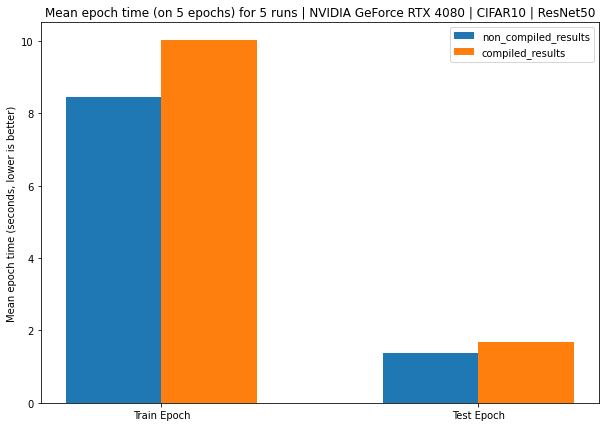

In [66]:
plot_mean_epoch_times(non_compile_results_multiple_runs_df, compile_results_multiple_runs_df, multi_runs=True, num_runs=NUM_RUNS)

In [69]:
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{dataset_name}_{model_name}_{gpu_name.replace(' ', '_')}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{dataset_name}_{model_name}_{gpu_name.replace(' ', '_')}.csv"
print(save_name_for_multi_run_non_compiled_results)
print(save_name_for_multi_run_compiled_results)

# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Save the results
results_df.to_csv(f"{pytorch_2_multi_run_results_dir}/{save_name_for_multi_run_non_compiled_results}")
compile_results_df.to_csv(f"{pytorch_2_multi_run_results_dir}/{save_name_for_multi_run_compiled_results}")

multi_run_non_compiled_results_5_runs_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_4080.csv
multi_run_compiled_results_5_runs_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_4080.csv


## TK - Possible improvements/extensions

* TK - use mixed precision training - https://pytorch.org/docs/stable/notes/amp_examples.html#amp-examples (more speedups)
* Transformer based models may see better speedups than conv models (due to PyTorch 2.0) - https://pytorch.org/blog/pytorch-2.0-release/#stable-accelerated-pytorch-2-transformers 